**Test with one subject and other subjects are training data**

**This one will be used for android application**

Current version is 1.15.0, need to install 1.13.1

///   !pip install -q -U tensorflow ==1.13.1

!pip install tensorflow==1.13.1

import tensorflow as tf

print(tf.__version__)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/HAR Dataset/HAR Mine")

In [0]:
!ls "/content/drive/My Drive/HAR Dataset/HAR Mine"

'Additional Testing Code'
'Basic Data'
 checkpoint
 converted_model.tflite
'data visualitaion.ipynb'
'Feature Test.ipynb'
'HAR get three activities.ipynb'
 human_activity_recognition_basic.ipynb
 human_activity_recognition_Classifier.ipynb
'Human Activity Recognition Classifier Result.gsheet'
 Human_activity_recognition_feature_extract.ipynb
 Human_activity_recognition_magnitude_Feature_extract.ipynb
 human_activity_recognition_MINE_2.ipynb
 human_activity_recognition_MINE.ipynb
 human_activity_recognition_with_raw_data.ipynb
 human_activity_recognition_with_raw_data_new_tech.ipynb
'Processed Data'
'RNN Result.gsheet'
'Subject with number activities performed.gsheet'
 wisdomDataRemoveJoggingActivity.ipynb


In [0]:
!pip install tensorflow==1.13.1

#import tensorflow as tf
#print(tf.version)

     |████████████████████████████████| 92.5MB 24kB/s 
     |████████████████████████████████| 368kB 49.3MB/s 
     |████████████████████████████████| 3.2MB 35.9MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


# Load Library

In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import seaborn as sn

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
print(tf.__version__)

1.13.1


# Load Data

In [0]:
#df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_50_window_size_without_overlapping.csv')
#df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_50_window_size_consecutive_activity_without_overlapping.csv')
#df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_50_window_size_with_50_percent_overlapping_4_subject.csv')

#df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_50_window_size_without_overlapping_with_three_activities.csv')
df = pd.read_csv('Processed Data/Three_activities_data_with__50_window_size_without_overlapping.csv')

df = df.dropna()

# Data Exploration

In [0]:
df.head()
#print(df['mean_x'])
#print(df['mean_x'].values[0])


,mean_x,mean_y,mean_z,magnitude_mean,std_x,std_y,std_z,magnitude_std,rms_x,rms_y,rms_z,magnitude_rms,min_x,min_y,min_z,magnitude_min,max_x,max_y,max_z,magnitude_max,median_x,median_y,median_z,magnitude_median,mad_x,mad_y,mad_z,magnitude_mad,corr_xy,corr_yz,corr_xz,subject,class
0,-1.644151,7.299989,-4.774019,9.194468,1.374718,1.303727,1.601727,0.633384,2.143148,7.415493,5.035552,9.216258,-3.890869,4.947205,-7.264801,7.616315,1.022034,10.116287,-0.647232,10.606999,-1.443993,7.268387,-4.960381,9.253738,1.145463,1.075877,1.239351,0.493521,0.803482,0.755901,0.724554,2,SITTING
1,-4.893322,2.375117,-8.347987,10.039573,0.647945,1.077232,0.453523,0.517292,4.936034,2.607989,8.360298,10.052891,-5.834961,0.261749,-9.491409,8.587557,-2.504623,5.095642,-7.202560,11.571552,-4.917984,1.873055,-8.333808,10.034463,0.466141,0.848993,0.334032,0.331420,0.147029,0.330089,0.287061,2,SITTING
2,-4.714092,1.146173,-8.771570,10.045569,0.542208,0.410817,0.462359,0.489795,4.745172,1.217573,8.783748,10.057503,-6.402389,-0.492416,-10.326981,9.372080,-3.649048,2.102890,-7.968704,12.089280,-4.677368,1.134445,-8.762375,9.961059,0.364911,0.280063,0.326969,0.301609,0.287382,0.298514,0.050644,2,SITTING
3,-4.440626,1.069510,-8.864417,9.972461,0.071734,0.047943,0.063884,0.049366,4.441206,1.070584,8.864647,9.972584,-4.570816,0.944107,-8.995804,9.865092,-4.271545,1.226624,-8.758789,10.071942,-4.436752,1.070999,-8.861740,9.964040,0.059195,0.035829,0.051725,0.042919,0.194947,0.208995,-0.454511,2,SITTING
4,-4.375648,0.917478,-8.933562,9.991692,0.120399,0.155448,0.059223,0.069623,4.377304,0.930554,8.933758,9.991934,-4.709686,0.434143,-9.072418,9.695230,-3.852570,1.159576,-8.753998,10.174546,-4.358940,0.938118,-8.938354,10.006441,0.077469,0.110670,0.045394,0.043270,-0.026265,0.537605,-0.009120,2,SITTING


# Data Preprocessing

In [0]:
unisubs = np.unique(df['subject'])
#unisubs = np.asarray([2,5,6,7])
print(unisubs)


#one_subject_segdata = df.loc[df['subject'] == unisubs[i]]


[2 4 5 6 7 8]


In [0]:
data = df.values
print(len(data), len(df), data.shape)
le = preprocessing.LabelEncoder()
y = le.fit_transform(data[:,-1].astype('str'))+1

subjects = np.unique(df['subject'])
#print(subjects)

activity_ids = np.unique(y)
n_class = len(activity_ids)
print(activity_ids)

3855 3855 (3855, 33)
[1 2 3]


In [0]:
columns = ['mean_x', 'mean_y', 'mean_z', 'magnitude_mean',
            'std_x', 'std_y', 'std_z', 'magnitude_std',
            'rms_x', 'rms_y', 'rms_z', 'magnitude_rms',
            'min_x', 'min_y', 'min_z', 'magnitude_min',
            'max_x', 'max_y', 'max_z', 'magnitude_max',
            'median_x', 'median_y', 'median_z', 'magnitude_median',
            'mad_x', 'mad_y', 'mad_z','magnitude_mad',
           'corr_xy','corr_yz', 'corr_xz',
            'subject',  'class']

N_TIME_STEPS = 5
N_FEATURES = 31
step = 2

In [0]:

def make_sequence(data):
  
  segments = []
  labels = []
  
  for i in range(0, len(data) - N_TIME_STEPS, step):
    sequence_array= []
    for j in range (0, len(columns)-2):
      sequence_array.append(data[columns[j]].values[i: i + N_TIME_STEPS])
    segments.append(sequence_array)
    
    #xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    #ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    #zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(data['class'][i: i + N_TIME_STEPS])[0][0]
    #segments.append([xs, ys, zs])
    labels.append(label)
  
  return segments, labels

In [0]:
#LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
LABELS = ['SITTING', 'STANDING', 'WALKING']

In [0]:
unisubs = np.unique(df['subject'])
subject = 4

train_data = df.loc[df['subject'] != subject]
test_data = df.loc[df['subject'] == subject]



In [0]:
train_segments, train_labels = make_sequence(train_data)
test_segments, test_labels = make_sequence(test_data)

print(len (train_data),np.asarray(train_segments).shape, type(train_labels), np.asarray(train_labels).shape)
print(len (test_data),np.asarray(test_segments).shape,type(test_labels), np.asarray(test_labels).shape)



reshaped_train_segments = np.asarray(train_segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
train_labels = np.asarray(pd.get_dummies(train_labels), dtype = np.float32)

reshaped_test_segments = np.asarray(test_segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
print(reshaped_train_segments.shape, len(train_labels))
print(reshaped_test_segments.shape, len(test_labels))

X_train = reshaped_train_segments
y_train =  train_labels
X_test = reshaped_test_segments
y_test = test_labels
  
  
  
print(type (X_train), X_train.shape, type (y_train), y_train.shape,)
print(type(X_test), X_test.shape, type(y_test), y_test.shape)

print(y_test[0])

#print(X_test[0])

3374 (1685, 31, 5) <class 'list'> (1685,)
481 (238, 31, 5) <class 'list'> (238,)
(1685, 5, 31) 1685
(238, 5, 31) 238
<class 'numpy.ndarray'> (1685, 5, 31) <class 'numpy.ndarray'> (1685, 3)
<class 'numpy.ndarray'> (238, 5, 31) <class 'numpy.ndarray'> (238, 3)
[1. 0. 0.]


# Building the model


In [0]:
#N_CLASSES = 5

N_CLASSES = 3
N_HIDDEN_UNITS = 64

In [0]:
def create_LSTM_model(inputs, is_train):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    
    
    X = tf.layers.batch_normalization(X, training= True)
    
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)
    #print(hidden)
    #tf.layers.batch_normalization(lstm_layers, training= True)
    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)
    
    #lstm_layers = tf.keras.layers.BatchNormalization(lstm_layers)
    
    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
    '''
    lstm_layers = [tf.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.nn.rnn_cell.MultiRNNCel(lstm_layers)
    outputs, _ = tf.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
    '''
    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

is_train = tf.placeholder(tf.bool, name ="is_train")

In [0]:
pred_Y = create_LSTM_model(X, is_train)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [0]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training


In [0]:
N_EPOCHS = 50
BATCH_SIZE = 32

In [0]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    #print(a, pred_softmax)
    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    '''
    if i != 1 and i % 10 != 0:
        continue
    '''
    print(f'epoch: {i} train accuracy: {acc_train} loss: {loss_train}')
    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')


epoch: 1 train accuracy: 0.9097923040390015 loss: 2.2196738719940186
epoch: 1 test accuracy: 0.6932772994041443 loss: 2.293086528778076
epoch: 2 train accuracy: 0.9875370860099792 loss: 1.8999748229980469
epoch: 2 test accuracy: 0.970588207244873 loss: 1.9530233144760132
epoch: 3 train accuracy: 0.9893175363540649 loss: 1.7964242696762085
epoch: 3 test accuracy: 0.9747899174690247 loss: 1.8735014200210571
epoch: 4 train accuracy: 0.9928783178329468 loss: 1.6889617443084717
epoch: 4 test accuracy: 0.9789915680885315 loss: 1.7422679662704468
epoch: 5 train accuracy: 0.9934718012809753 loss: 1.5850310325622559
epoch: 5 test accuracy: 0.9789915680885315 loss: 1.6366113424301147
epoch: 6 train accuracy: 0.995252251625061 loss: 1.4837132692337036
epoch: 6 test accuracy: 0.9789915680885315 loss: 1.5326037406921387
epoch: 7 train accuracy: 0.9946587681770325 loss: 1.3869664669036865
epoch: 7 test accuracy: 0.9831932783126831 loss: 1.436733603477478
epoch: 8 train accuracy: 0.9934718012809753 l

In [0]:
print(activity_ids)
activity_ids = np.unique(y)-1
print(activity_ids)

[1 2 3]
[0 1 2]


In [0]:

def classification_report(cm):

  true_pos = np.diag(cm)
  false_pos = np.sum(cm, axis=0) - true_pos
  false_neg = np.sum(cm, axis=1) - true_pos

  precision = true_pos / (true_pos+false_pos)
  recall = true_pos / (true_pos + false_neg)
  
  f1_score = 2/(precision**-1 + recall**-1)
  return precision, recall, f1_score

accuracy  0.9789915966386554
precision, recall, f1score, accuracy
0.9800177720041318 0.9789915966386554 0.9789653206265494 0.9789915966386554
class-wise precision: [0.94202899 0.98765432 1.        ]
class-wise recall: [1.         1.         0.94623656]
class-wise f1score: [0.97014925 0.99378882 0.97237569]
class-wise accuracy: [1.         1.         0.94623656]
[[65  0  0]
 [ 0 80  0]
 [ 4  1 88]]


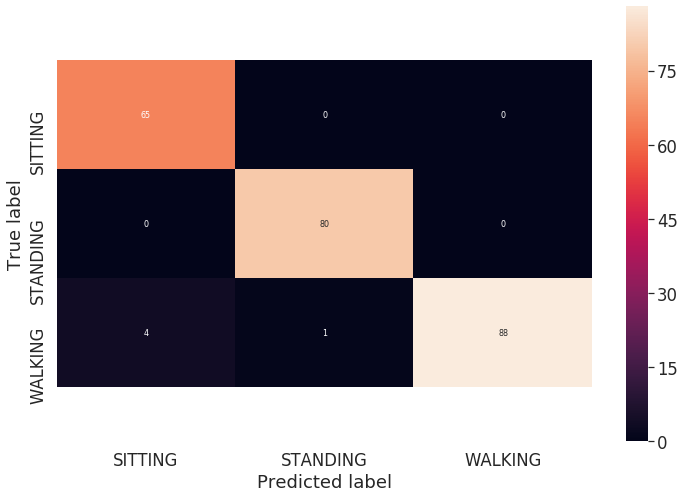

In [0]:
#print(type(y_test), y_test.shape, y_test[0])

test_y = np.argmax(y_test, axis=1)
#print(type(test_y), test_y.shape, test_y[0])
#print(test_y)



#print(predictions)
#print(type(predictions), predictions.shape, predictions[0])
l= np.argmax(predictions, axis=1)
#print (type(l), l.shape, l)
#print (type(l), l.shape)

pred = activity_ids[np.argmax(predictions, axis=1)]
#print(type(pred),pred.shape, pred)


acc = accuracy_score(test_y, pred)

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, pred, average='weighted')
print('accuracy ', acc)
print("precision, recall, f1score, accuracy")
print( precision,recall,f1score,acc)

#print ( ">>> ", type(test_y),test_y.shape, type(pred), pred.shape)

cm_all = confusion_matrix(test_y, pred)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))

#array = confusion_matrix(true_all, pred_all)
array = confusion_matrix(test_y, pred)
#df_cm = pd.DataFrame(array, range(5),range(5))
df_cm = pd.DataFrame(array, range(3),range(3))
#sn.set(font_scale=1)#for label size
#sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
#sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING'))

ax = sn.heatmap(df_cm, annot=True,fmt='g',annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING'),xticklabels=('SITTING', 'STANDING', 'WALKING'))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()


In [0]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))

In [0]:

#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'checkpoint/har.pbtxt')  
saver.save(sess, save_path = "checkpoint/har.ckpt")


'''
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
#tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
#saver.save(sess, save_path = "./checkpoint/har.ckpt")

tf.train.write_graph(sess.graph_def, '.', 'har.pbtxt')  
saver.save(sess, save_path = "har.ckpt")
sess.close()


'''

'\npickle.dump(predictions, open("predictions.p", "wb"))\npickle.dump(history, open("history.p", "wb"))\n#tf.train.write_graph(sess.graph_def, \'.\', \'./checkpoint/har.pbtxt\')  \n#saver.save(sess, save_path = "./checkpoint/har.ckpt")\n\ntf.train.write_graph(sess.graph_def, \'.\', \'har.pbtxt\')  \nsaver.save(sess, save_path = "har.ckpt")\nsess.close()\n\n\n'

In [0]:
sess.close()

In [0]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

# Evaluation

In [0]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

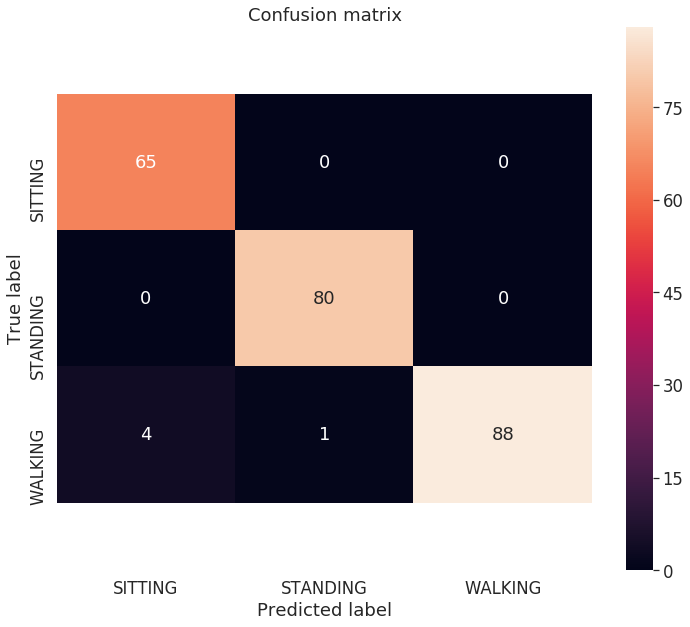

In [0]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(12, 10))
#sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

ax = sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [0]:
# tensprflow cpu VERSION 1.13.1
print(tf.__version__)

1.13.1



# Exporting the model


In [0]:
from tensorflow.python.tools import freeze_graph

#MODEL_NAME = 'har'
MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'
#output_frozen_graph_name = 'frozen_model_new2'+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Instructions for updating:
Use tf.gfile.GFile.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


#convert to tflite model

In [0]:
# tensprflow cpu VERSION 1.13.1
# print(tf.__version__)

graph_def_file = 'frozen_'+MODEL_NAME+'.pb'
#graph_def_file = "frozen_model_new2.pb"
input_arrays = ["input"]
output_arrays = ["y_"]

converter = tf.lite.TFLiteConverter.from_frozen_graph(
  graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

304640

In [0]:

# Check the converted TensorFlow Lite model.
interpreter = tf.lite.Interpreter(model_content=tflite_model)

try:
  interpreter.allocate_tensors()
except ValueError:
  assert False

MINI_BATCH_SIZE = 1
correct_case = 0
for i in range(len(X_test)):
  input_index = (interpreter.get_input_details()[0]['index'])
  interpreter.set_tensor(input_index, X_test[i * MINI_BATCH_SIZE: (i + 1) * MINI_BATCH_SIZE])
  interpreter.invoke()
  output_index = (interpreter.get_output_details()[0]['index'])
  result = interpreter.get_tensor(output_index)
  # Reset all variables so it will not pollute other inferences.
  interpreter.reset_all_variables()
  # Evaluate.
  #print(result)
  prediction = np.argmax(result)
  #print(prediction, y_test[i],np.argmax(y_test[i]))
  if prediction == np.argmax(y_test[i]):
    correct_case += 1
#print (correct_case)
#print('TensorFlow Lite Evaluation result is {}'.format(correct_case * 1.0 / len(X_test)))